## Exploring Maritime Freight data – container volume and metric tonnage – in the U.S. 

Source: https://www.marad.dot.gov/resources/data-statistics/

In [420]:
#Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Loading and arranging / formatting data

Our data is in 6 separate CSV files, so we'll need to load them in one-by-one, make a few transformations, and then join them into two sets of three. In total, we have:

* Total TEU
* Import TEU
* Export TEU
* Total MT
* Import MT
* Export MT

In [421]:
#Load data
totalTEU = pd.read_csv("totalTEU.csv")
importTEU = pd.read_csv("importTEU.csv")
exportTEU = pd.read_csv("exportTEU.csv")
totalMT = pd.read_csv("totalMT.csv")
importMT = pd.read_csv("importMT.csv")
exportMT = pd.read_csv("exportMT.csv")

The data is coming in a little jumbled, so here's the workflow we're going to implement for each of our 6 dataframes:

* Create a separate dataframe for the coast of each port
* Delete the "coast" column from each dataframe
* Melt down each dataframe into 3 columns: port, year, and respective value (totalTEU, importMT, etc.)
* Merge all 6 dataframes together into one shipping dataframe
* Convert numeric fields from strings to integers

In [422]:
#Create a new dataframe of each city and its respective coast
coasts = totalTEU[['Coast','U.S. Custom Ports']]
#Set the index to the city
coasts.set_index('U.S. Custom Ports', inplace=True)

In [423]:
#Drop the coasts row from the dataframes
for df in [totalTEU, importTEU, exportTEU, totalMT, importMT, exportMT]:
    del df['Coast']

In [424]:
#Melt down each dataframe into 3 columns: port, year, and respective value
totalTEU = totalTEU.melt(id_vars='U.S. Custom Ports', var_name='year', value_name='totalTEU')
importTEU = importTEU.melt(id_vars='U.S. Custom Ports', var_name='year', value_name='importTEU')
exportTEU = exportTEU.melt(id_vars='U.S. Custom Ports', var_name='year', value_name='exportTEU')
totalMT = totalMT.melt(id_vars='U.S. Custom Ports', var_name='year', value_name='totalMT')
importMT = importMT.melt(id_vars='U.S. Custom Ports', var_name='year', value_name='importMT')
exportMT = exportMT.melt(id_vars='U.S. Custom Ports', var_name='year', value_name='exportMT')

In [425]:
#Merge together all TEU measures
TEUs = pd.merge(totalTEU,importTEU, on=['U.S. Custom Ports', 'year']).merge(exportTEU, on=['U.S. Custom Ports', 'year'])
#Merge together all MT measures
MTs = pd.merge(totalMT,importMT, on=['U.S. Custom Ports', 'year']).merge(exportMT, on=['U.S. Custom Ports', 'year'])
#Merge together everything
shipping = pd.merge(TEUs, MTs, on=['U.S. Custom Ports', 'year'])

In [426]:
#Since some of the numbers are floats/ints and some are strings, we'll need to create a function to clean them
def cleanNum(x):
    if type(x) != str:
        return x
    elif type(x) == str:
        return float(x.replace(',',''))

In [427]:
#Apply our cleanNum function to 
for col in shipping.loc[:,'totalTEU':]:
    shipping[col] = shipping[col].apply(cleanNum)

In [428]:
shipping.tail()

,U.S. Custom Ports,year,totalTEU,importTEU,exportTEU,totalMT,importMT,exportMT
987,"Tampa, FL",2015,38406.0,28055.0,10352.0,337579.0,221477.0,116102.0
988,"Vancouver, WA",2015,2752.0,1836.0,916.0,27401.0,13939.0,13462.0
989,"West Palm Beach, FL",2015,164028.0,29863.0,134164.0,1372871.0,357895.0,1014976.0
990,"Wilmington, DE",2015,194529.0,164912.0,29618.0,1821914.0,1621830.0,200084.0
991,"Wilmington, NC",2015,232118.0,124698.0,107420.0,2002633.0,896591.0,1106042.0


### Basic overview

To get a better idea of what we're looking at, let's look at some summary statistic and basic data plots.

In [429]:
#To make indexing slightly easier
shipping = shipping.rename(columns = {'U.S. Custom Ports': 'port'})

In [432]:
pd.options.display.float_format = '{:.1f}'.format
shipping.describe()

,totalTEU,importTEU,exportTEU,totalMT,importMT,exportMT
count,991.0,992.0,992.0,992.0,992.0,992.0
mean,425954.6,261785.3,159417.9,3413283.6,1884284.4,1528999.2
std,1001895.5,693505.5,326867.2,7589919.9,4579770.2,3177258.9
min,0.0,0.0,0.0,0.0,0.0,0.0
25%,238.5,72.0,56.5,2429.2,666.0,582.0
50%,23842.0,13147.5,8565.5,208243.0,104056.0,72146.0
75%,210903.0,121558.5,103519.8,1987326.5,1208895.8,943993.8
max,6019633.0,4426542.0,1953607.0,44803371.0,26999878.0,20167385.0


Some initial notes we can get from the above:

1) The average U.S. port imports 1.65x TEUs as it exports, but only 1.23x the Metric Tonnage.

In [439]:
print("Average import TEUs: " + str(shipping['importTEU'].mean()))
print("Average export TEUs: " + str(shipping['exportTEU'].mean()))
print("Import to export TEU ratio: " + str(shipping['importTEU'].mean()/ shipping['exportTEU'].mean()))
print("\n")
print("Average import MTs: " + str(shipping['importMT'].mean()))
print("Average export MTs: " + str(shipping['exportMT'].mean()))
print("Import to export MT ratio: " + str(shipping['importMT'].mean()/ shipping['exportMT'].mean()))

Average import TEUs: 261785.251008
Average export TEUs: 159417.943548
Import to export TEU ratio: 1.64213165207


Average import MTs: 1884284.4123
Average export MTs: 1528999.17238
Import to export MT ratio: 1.23236457307


2) Given that the mean and median are so far off each other, our distribution might be skewed. 

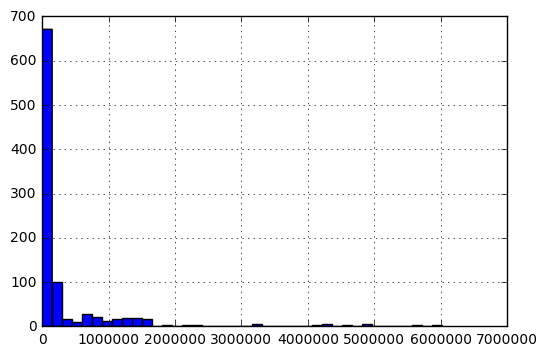

In [444]:
shipping['totalTEU'].hist(bins=40)

The histogram shows a significant skew with a long right tail. To clean this up a little bit, we can also take the average TEUs shipped for each port and plot a histogram of that.

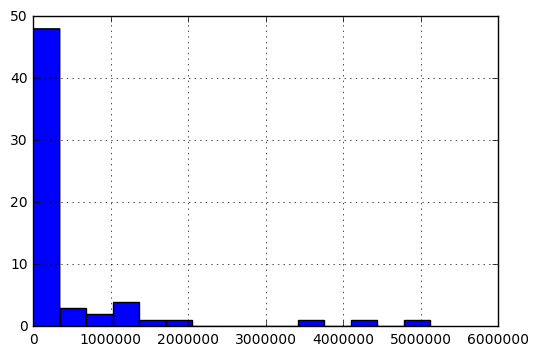

In [464]:
shipping.groupby('port').mean()['totalTEU'].hist(bins=15)

It also doesn't seem like there are any ports in the dataset that have never shipped a TEU. So there are some ports that are shipping *very few* items, but not none.

In [465]:
sum(shipping.groupby('port').sum()['totalTEU'] == 0)

0

In summary, we can safely say that within our dataset there's a long tail for U.S. ports – a small amount of the ports in the dataset ship the overwhelming majority of TEUs.

### Which ports import and export the most?

In [468]:
#Highest average shipping volume
shipping.groupby('port').mean()['totalTEU'].sort_values(ascending=False).head()

port
Los Angeles, CA   5118301.1
Long Beach, CA    4187237.1
New York, NY      3599193.8
Savannah, GA      1790583.9
Norfolk, VA       1412938.9
Name: totalTEU, dtype: float64

In [471]:
#Highest average import volume
shipping.groupby('port').mean()['importTEU'].sort_values(ascending=False).head()

port
Los Angeles, CA   3749933.1
Long Beach, CA    3044610.0
New York, NY      2421513.9
Savannah, GA       918261.5
Norfolk, VA        746568.2
Name: importTEU, dtype: float64

In [473]:
#Highest average export volume
shipping.groupby('port').mean()['exportTEU'].sort_values(ascending=False).head()

port
Los Angeles, CA   1366294.8
New York, NY      1156409.8
Long Beach, CA    1131249.9
Savannah, GA       872297.4
Houston, TX        695983.2
Name: exportTEU, dtype: float64

LA, NYC, Long Beach, and Savannah occupy the top 4 spots on all 3 of these lists. The fifth spot goes to Norfolk for total TEUs and imported TEUs, but Houston has the slot for exports.

Like we saw above in the descriptive statistics, the average U.S. port imports 1.6x as much as it exports. The top 5 ratios by port:

In [482]:
imports = shipping.groupby('port').mean()['importTEU']
exports = shipping.groupby('port').mean()['exportTEU']
(exports / imports).sort_values(ascending=False).head(10)

port
Kodiak, AK               inf
Anacortes, WA          182.0
Anchorage, AK           45.7
Camden, NJ              12.6
Lake Charles, LA         4.9
Aberdeen, WA             4.2
Longview, WA             4.2
Brunswick, GA            3.9
West Palm Beach, FL      3.5
Fernandina Beach, FL     2.5
dtype: float64

In [480]:
expRatio.sort_values(ascending=False).head(10)

port
Kodiak, AK               inf
Anacortes, WA          182.0
Anchorage, AK           45.7
Camden, NJ              12.6
Lake Charles, LA         4.9
Aberdeen, WA             4.2
Longview, WA             4.2
Brunswick, GA            3.9
West Palm Beach, FL      3.5
Fernandina Beach, FL     2.5
dtype: float64

### Which ports import the heaviest and lightest freight?

The ratio of Metric Tons to TEUs shipped should indicate how heavy freight typically is at a given port.

In [491]:
weight = shipping.groupby('port').mean()['totalMT'] / shipping.groupby('port').mean()['totalTEU']

In [492]:
weight.sort_values(ascending=False).head()

port
Port Arthur, TX    685.3
Beaumont, TX        17.0
Port Angeles, WA    16.5
Baton Rouge, LA     15.3
Gramercy, LA        14.3
dtype: float64

In [493]:
weight.sort_values(ascending=True).head()

port
Pensauken, NJ        2.6
Jacksonville, FL     4.8
Mayaguez, PR         5.1
Port Canaveral, FL   6.4
Aberdeen, WA         6.6
dtype: float64

Port Arthur, TX has an outsized weight ratio (way more MT shipped than TEU).

### Mapping the relative size of ports

In [659]:
from mpl_toolkits.basemap import Basemap as Basemap
from geopy.geocoders import Nominatim
import math

In [660]:
#Separate ports and totalTEU into a dataframe for plotting
ports = shipping.groupby('port').mean()['totalTEU']

In [661]:
#Remove the state from each city and insert into new list
portCities = []
for port in ports.index:
    portCity = port.split(',')[0]
    portCities.append(portCity)

In [662]:
#Create a new tuple with the index as cities
portsMap = zip(portCities, ports)
#Sort tuples by totalTEU value
portsMap.sort(key=lambda x: x[1])

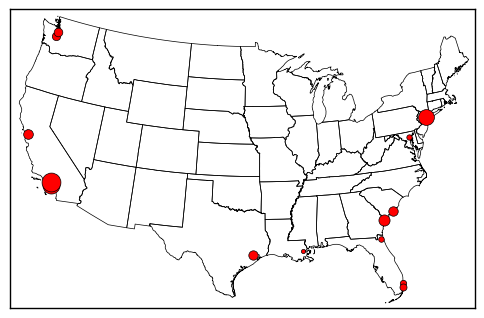

In [668]:
#Get the location of each city and plot it
scale = .006
map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=32,lat_2=45,lon_0=-95)
# load the shapefile, use the name 'states'
map.readshapefile('st99_d00', name='states', drawbounds=True)

geolocator = Nominatim()
#Use only the top 15 ports by totalTEU
for (port,TEU) in portsMap[47:62]:
    try:
        loc = geolocator.geocode(port)
        x, y = map(loc.longitude, loc.latitude)
        map.plot(x,y,marker='o',color='Red',markersize=int(math.sqrt(TEU))*scale)
    except AttributeError:
        pass
plt.show()